# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Your code here :
from tensorflow.keras.preprocessing.text import Tokenizer

# Inicializar el Tokenizer
tokenizer = Tokenizer()

# Ajustar el Tokenizer al corpus
tokenizer.fit_on_texts(corpus)




Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
# Your code here :
# Calcular el tamaño del vocabulario
total_words = len(tokenizer.word_index) + 1
print(f"El tamaño total del vocabulario es: {total_words}")


El tamaño total del vocabulario es: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
# Your code here :
# Crear una lista vacía para almacenar las secuencias de entrada
input_sequences = []

# Para cada oración en el corpus
for line in corpus:
    # Convertir la línea de texto en una secuencia de números usando el tokenizer
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Generar n-gramas a partir de esta secuencia de tokens
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]
        input_sequences.append(n_gram_sequence)

# Ver un ejemplo de las primeras secuencias generadas
print("Primeras secuencias de entrada (input_sequences):")
print(input_sequences[:10])


Primeras secuencias de entrada (input_sequences):
[[878], [3], [3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118], [118, 1376], [118, 1376, 878], [1377]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Your code here :
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Calcular la longitud de la secuencia más larga
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"La longitud máxima de una secuencia es: {max_sequence_len}")

# Rellenar las secuencias para que todas tengan la misma longitud
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Convertir las secuencias rellenadas a un array de NumPy
input_sequences = np.array(input_sequences)

# Ver las primeras secuencias rellenas como ejemplo
print("Primeras secuencias tras el padding:")
print(input_sequences[:5])


La longitud máxima de una secuencia es: 11
Primeras secuencias tras el padding:
[[   0    0    0    0    0    0    0    0    0    0  878]
 [   0    0    0    0    0    0    0    0    0    0    3]
 [   0    0    0    0    0    0    0    0    0    3    2]
 [   0    0    0    0    0    0    0    0    3    2  313]
 [   0    0    0    0    0    0    0    3    2  313 1375]]


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Your code here :
# Dividir las secuencias en predictores (X) y etiquetas (y)
predictors = input_sequences[:, :-1]  # Todos los elementos excepto el último
labels = input_sequences[:, -1]      # Solo el último elemento de cada secuencia

# Convertir las etiquetas a formato categórico para el modelo
labels = ku.to_categorical(labels, num_classes=total_words)

# Verificar las dimensiones de los predictores y etiquetas
print(f"Dimensiones de Predictors (X): {predictors.shape}")
print(f"Dimensiones de Labels (y): {labels.shape}")

# Ver ejemplos de Predictors y Labels
print("Ejemplo de Predictors (X):")
print(predictors[:5])

print("Ejemplo de Labels (y):")
print(labels[:5])


Dimensiones de Predictors (X): (17805, 10)
Dimensiones de Labels (y): (17805, 3375)
Ejemplo de Predictors (X):
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   3   2]
 [  0   0   0   0   0   0   0   3   2 313]]
Ejemplo de Labels (y):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
# Dividir las secuencias en predictores (X) y etiquetas (y)
predictors = input_sequences[:, :-1]  # Todos los elementos excepto el último
labels = input_sequences[:, -1]      # Solo el último elemento de cada secuencia

# Revisar que las variables estén definidas correctamente
print(f"Predictors definidos: {predictors.shape}")
print(f"Labels definidos: {labels.shape}")


Predictors definidos: (17805, 10)
Labels definidos: (17805,)


In [9]:
# Codificar las etiquetas en formato one-hot
labels = ku.to_categorical(labels, num_classes=total_words)

# Verificar las dimensiones de las etiquetas tras la codificación
print(f"Dimensiones de Labels (y) después de one-hot encoding: {labels.shape}")


Dimensiones de Labels (y) después de one-hot encoding: (17805, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

# Inicializar el modelo secuencial
model = Sequential()

# Capa 1: Embedding
model.add(Embedding(input_dim=total_words,  # Tamaño del vocabulario
                    output_dim=100,        # Dimensión del vector de embedding
                    input_length=max_sequence_len - 1))  # Longitud de entrada (secuencia previa)

# Capa 2: Bidirectional LSTM
model.add(Bidirectional(LSTM(150, return_sequences=True)))

# Capa 3: Dropout
model.add(Dropout(0.2))

# Capa 4: Segunda LSTM
model.add(LSTM(100))

# Capa 5: Dense intermedia
model.add(Dense(total_words // 2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))  # Regularización L2

# Capa 6: Dense de salida
model.add(Dense(total_words, activation='softmax'))  # Predicción de la próxima palabra

# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Ver la arquitectura del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [ ]:
# Your code here :
# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Ver la arquitectura del modelo
model.summary()

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [ ]:
# Your code here :
# Ver la arquitectura del modelo
model.summary()

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [11]:
# Your code here :
# Entrenar el modelo
history = model.fit(
    predictors,       # Datos de entrada (secuencias anteriores)
    labels,           # Etiquetas (próxima palabra en formato one-hot)
    epochs=50,        # Número de épocas
    verbose=1         # Mostrar detalles del entrenamiento
)

# Confirmar que el modelo fue entrenado
print("Entrenamiento finalizado.")


Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.0224 - loss: 7.2237
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.0279 - loss: 6.4310
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0261 - loss: 6.3208
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0371 - loss: 6.2211
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0481 - loss: 6.0880
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0469 - loss: 6.0450
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0498 - loss: 5.9405
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0545 - loss: 5.8584
Epoch 9/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0614 - loss: 5.7378
Epoch 10/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0605 - loss: 5.6836
Epoch 11/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0670 - loss: 5.5878
Epoch 12/50
557/557 ━━━━━━━━━━━━━

**Guardar el Modelo**

In [13]:
model.save("shakespeare_text_gen_model.keras")



# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

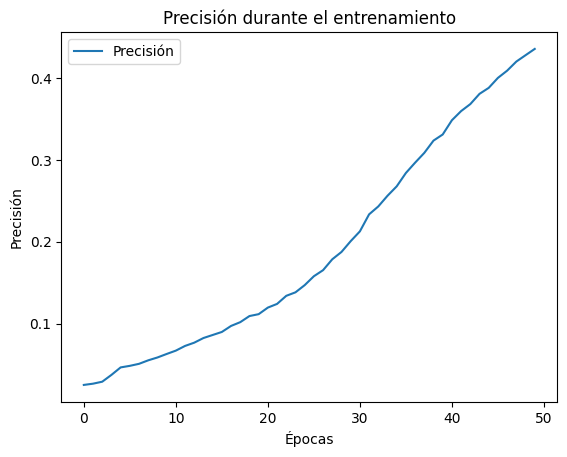

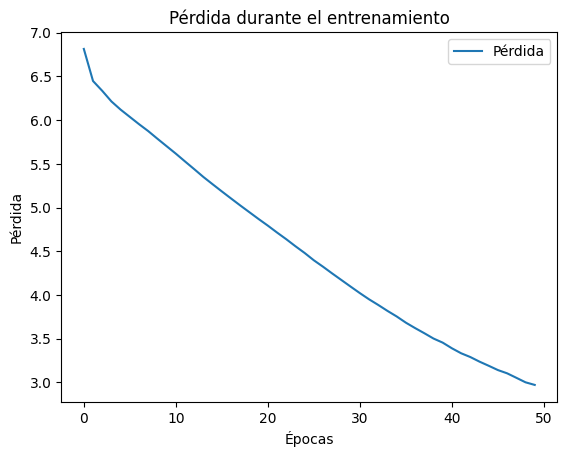

In [14]:
# Your code here :

import matplotlib.pyplot as plt

# Extraer la precisión y la pérdida del historial
accuracy = history.history['accuracy']
loss = history.history['loss']

# Graficar la precisión durante las épocas
plt.plot(accuracy, label='Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

# Graficar la pérdida durante las épocas
plt.plot(loss, label='Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [16]:
import numpy as np

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len):
    for _ in range(next_words):
        # Convertir el texto inicial en una secuencia de tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Rellenar (pad) la secuencia para que coincida con la longitud máxima
        token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
        token_list = np.array([token_list])

        # Predecir la siguiente palabra
        predicted = np.argmax(model.predict(token_list), axis=-1)

        # Buscar la palabra correspondiente al token predicho
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        # Añadir la palabra predicha al texto inicial
        seed_text += " " + output_word

    return seed_text



In [18]:
import numpy as np

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len):
    for _ in range(next_words):
        # Convertir el texto inicial en una secuencia de tokens
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Asegurarse de que la longitud de la secuencia no sea mayor a max_sequence_len - 1
        if len(token_list) >= max_sequence_len - 1:
            token_list = token_list[-(max_sequence_len - 1):]

        # Rellenar (pad) la secuencia para que coincida con la longitud máxima
        token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
        token_list = np.array([token_list])

        # Predecir la siguiente palabra
        predicted = np.argmax(model.predict(token_list), axis=-1)

        # Buscar la palabra correspondiente al token predicho
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        # Añadir la palabra predicha al texto inicial
        seed_text += " " + output_word

    return seed_text


In [19]:
# Define el texto semilla
seed_text = "Write the text you want the model to use as a starting point to generate the next words"

# Define el número de palabras que deseas generar
next_words = 20

# Generar texto
generated_text = generate_text(seed_text, next_words, model, tokenizer, max_sequence_len)

# Imprimir el texto generado
print("Texto generado:")
print(generated_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Texto generado:
Write the text you want the model to use as a starting point to generate the next words of wound it eyes to thee did so gone still alone not so love more true more shall more gone


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [20]:
# Your code here :
# Define el texto semilla
seed_text = "Shall I compare thee to a summer's day"
next_words = 20  # Número de palabras que quieres generar

# Crear el bucle para generar el texto
for _ in range(next_words):
    # Convertir el texto inicial en una secuencia de tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Asegurarse de que la longitud de la secuencia no sea mayor a max_sequence_len - 1
    if len(token_list) >= max_sequence_len - 1:
        token_list = token_list[-(max_sequence_len - 1):]

    # Rellenar (pad) la secuencia para que coincida con la longitud máxima
    token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
    token_list = np.array([token_list])

    # Predecir la siguiente palabra
    predicted = np.argmax(model.predict(token_list), axis=-1)

    # Buscar la palabra correspondiente al token predicho
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # Añadir la palabra predicha al texto inicial
    seed_text += " " + output_word

# Imprimir el texto generado completo
print("Texto generado completo:")
print(seed_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Texto generado completo:
Shall I compare thee to a summer's day lies not be eye when 'will days ' ' alone still prove bright more and wrought crave nought of stand


Experiment with at least 3 different seed_text strings and see what happens!

In [21]:
# Your code here :

# Your code here :
# Define el texto semilla
seed_text = "To be or not to be"

next_words = 20  # Número de palabras que quieres generar

# Crear el bucle para generar el texto
for _ in range(next_words):
    # Convertir el texto inicial en una secuencia de tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Asegurarse de que la longitud de la secuencia no sea mayor a max_sequence_len - 1
    if len(token_list) >= max_sequence_len - 1:
        token_list = token_list[-(max_sequence_len - 1):]

    # Rellenar (pad) la secuencia para que coincida con la longitud máxima
    token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
    token_list = np.array([token_list])

    # Predecir la siguiente palabra
    predicted = np.argmax(model.predict(token_list), axis=-1)

    # Buscar la palabra correspondiente al token predicho
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # Añadir la palabra predicha al texto inicial
    seed_text += " " + output_word

# Imprimir el texto generado completo
print("Texto generado completo:")
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Texto generado completo:
To be or not to be now thee are torn love dead beauty light eye more gone shade more nearly stand still from love me more


Implementar control de temperatura

In [22]:
# Your code here :

# Your code here :
# Define el texto semilla
seed_text = "Love is a smoke raised with the fume of sighs"



next_words = 20  # Número de palabras que quieres generar

# Crear el bucle para generar el texto
for _ in range(next_words):
    # Convertir el texto inicial en una secuencia de tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Asegurarse de que la longitud de la secuencia no sea mayor a max_sequence_len - 1
    if len(token_list) >= max_sequence_len - 1:
        token_list = token_list[-(max_sequence_len - 1):]

    # Rellenar (pad) la secuencia para que coincida con la longitud máxima
    token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
    token_list = np.array([token_list])

    # Predecir la siguiente palabra
    predicted_probs = model.predict(token_list)
    predicted = np.random.choice(range(total_words), p=predicted_probs.flatten())


    # Buscar la palabra correspondiente al token predicho
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # Añadir la palabra predicha al texto inicial
    seed_text += " " + output_word

# Imprimir el texto generado completo
print("Texto generado completo:")
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Texto generado completo:
Love is a smoke raised with the fume of sighs treasure ' of ground men of eye time more love a devil new chary ill will untrue love ' more


Añadir control de temperatura:

In [23]:
# Your code here :

# Your code here :
# Define el texto semilla
seed_text = "O mistress mine, where are you roaming"




next_words = 20  # Número de palabras que quieres generar

# Crear el bucle para generar el texto
for _ in range(next_words):
    # Convertir el texto inicial en una secuencia de tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Asegurarse de que la longitud de la secuencia no sea mayor a max_sequence_len - 1
    if len(token_list) >= max_sequence_len - 1:
        token_list = token_list[-(max_sequence_len - 1):]

    # Rellenar (pad) la secuencia para que coincida con la longitud máxima
    token_list = np.pad(token_list, (max_sequence_len - len(token_list) - 1, 0), 'constant')
    token_list = np.array([token_list])

    # Predecir la siguiente palabra
    predicted_probs = model.predict(token_list)[0]
    predicted_probs = np.exp(predicted_probs / 1.0) / np.sum(np.exp(predicted_probs / 1.0))
    predicted = np.random.choice(range(total_words), p=predicted_probs)



    # Buscar la palabra correspondiente al token predicho
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    # Añadir la palabra predicha al texto inicial
    seed_text += " " + output_word

# Imprimir el texto generado completo
print("Texto generado completo:")
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Texto generado completo:
O mistress mine, where are you roaming uphold phoenix addeth rebel sire scanted xxxvi healthful breathers swerving quietus honest unthrifts bosom nought fair excusing duty dressing pitied
